In [1]:
import os
os.environ["THEANO_FLAGS"]='device=gpu1'

In [2]:
from IPython.display import clear_output
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import copy
from replay_memory import ReplayMemory
from grid_world_v2 import GridWorld

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.callbacks import Callback
from random import shuffle

from keras.layers import MaxPooling2D, Flatten
from keras.layers import Convolution2D

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 1: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (4007, 5005))


In [3]:
grid_world = GridWorld()
grid_world.print_grid()

 ------------------------
|    .    .    .    .    |
|    .    . C1 .    . C2 |
|    .    . C3 .    .    |
|    .    .    .    .    |
|    .    .    .    .    |
 ------------------------


## DQN Class

In [4]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [5]:
class DQN(object):
    def __init__(self, gamma = 0.975,epsilon = 1, epsilon_decay = .99, terminal_reward = 10, env = None,
        memory = None, reward_discount_factor = 0.0, model_name=None, total_cars = 3, grid_size = 6):
        
        self.env = env
        self.losses = []
        self.all_games_history = []
        self.replay = memory
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.reward_discount_factor = reward_discount_factor
        self.terminal_reward = terminal_reward
        self.grid_size = grid_size
        self.total_cars = total_cars
        self.model = self.loadModel(model_name)
    
    def loadModel(self,model_name):
        if model_name == 'Naive':
            model = 'Naive'
            return model
        else:
#             model = Sequential()
#             model.add(Dense(256, init='lecun_uniform', input_shape=(self.env.observation_shape,)))
#             model.add(Activation('relu'))
#             model.add(Dropout(0.2))
#             model.add(Dense(256, init='lecun_uniform'))
#             model.add(Activation('relu'))
#             model.add(Dropout(0.2))
#             model.add(Dense(5, init='lecun_uniform'))
#             model.add(Activation('linear')) 
            model = Sequential()
            model.add(Convolution2D(32, 3, 3, input_shape=(4, env.grid_size, env.grid_size),activation='relu'))
            model.add(Convolution2D(32, 3, 3, activation='relu'))
            model.add(Convolution2D(32, 3, 3,activation='relu'))
            model.add(Convolution2D(32, 3, 3,activation='relu'))
            model.add(Flatten())
            model.add(Dense(256, activation='relu'))
            model.add(Dense(env.num_actions, init='lecun_uniform'))
            model.add(Activation('linear')) 
    
            if model_name != None:
                model.load_weights(model_name)
                model.compile(loss="mse", optimizer = RMSprop())
                return model

            else:
                model.compile(loss="mse", optimizer = RMSprop())
                return model
        
    
    def createTraining(self, minibatch):
        X_train = []
        y_train = []
        for memory in minibatch:
            old_state_m, action_m, reward_m, new_state_m,terminal_m = memory
            #old_qval = self.model.predict(old_state_m.reshape(1,self.env.observation_shape), batch_size=1)
            #newQ = self.model.predict(new_state_m.reshape(1,self.env.observation_shape), batch_size=1)
            old_qval = self.model.predict(np.array((old_state_m,)), batch_size=1)
            newQ = self.model.predict(np.array((new_state_m,)), batch_size=1)
            maxQ = np.max(newQ)

            y = np.zeros((1,self.env.num_actions))
            y[:] = old_qval[:]

            if not terminal_m:
                update = (reward_m + (self.gamma * maxQ))
            else:
                update = reward_m

            y[0][action_m] = update

            #X_train.append(old_state_m.reshape(self.env.observation_shape,))
            X_train.append(old_state_m)
            y_train.append(y.reshape(self.env.num_actions,))

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        return X_train,y_train
    
    def graphLoss(self):
        epochs = []
        losses_A = []
        count = 0
        for y in self.losses:
            losses_A.append(y[0])
            epochs.append(count)
            count = count + 1
        plt.plot(epochs[:],losses_A[:])
        
    def train(self, epochs, episodes, max_episode_length,output_weights_name):
        for i in range(epochs + 1):
            for j in range(episodes):
                terminal = False
                self.env.reset()
                
                while(not terminal and self.env.t < max_episode_length):
                    self.env.t += 1
                    print ("Epoch #: %s" % (i,))
                    print("Game #: %s" % (j,))
                    print ("Timestep #: %s" % (self.env.t,))
                    print ('Epsilon : ', float(self.epsilon))
                    self.env.print_grid()

                    #Bookeeping
                    curr_history = {}
                    curr_history['t'] = self.env.t
                    curr_history['curr_state'] = (self.env.cars_grid.copy(), self.env.cust_grid.copy())  

                    #Step all agents 1 timestep
                    all_agents_step = self.env.stepAll(self.model,self.epsilon)
                    
                    #More Bookeeping
                    curr_history['actions'] = all_agents_step
                    curr_history['next_state'] = (self.env.cars_grid.copy(), self.env.cust_grid.copy())
                    self.env.history.append(curr_history)  

                    #Check if terminal amount of cutomers picked up to end episode
                    terminal = self.env.isTerminal()
                    clear_output(wait=True)
                    
                    #Add memory to replay
                    for memory in all_agents_step:
                        self.replay.addToMemory(memory, terminal)

                #After each game/episode fit the network with a minibatch sampled from the replay memory
                if self.replay.isFull():
                    minibatch = self.replay.getMinibatch()
                    X_train, y_train = self.createTraining(minibatch)  
                    history = LossHistory()
                    self.model.fit(X_train, y_train, batch_size = self.replay.batchSize, nb_epoch=1, verbose=1,callbacks=[history])
                    self.losses.append(history.losses)

                #Append Bookept Hostory
                self.all_games_history.append(self.env.history)

            #Exponentially decay epsilon and run test metrics
            if self.replay.isFull():
                self.epsilon = self.epsilon * self.epsilon_decay
                if np.mod(i,20) == 0:
                    self.model.save_weights('weights/' + output_weights_name + '_'+ str(i) +'.h5', overwrite=True)

## Train Model

In [6]:
obstacle_grid = np.array([[0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0],
                          [0,0,0,1,1,1,1,0,0,0]])

In [11]:
memory = ReplayMemory(buffer = 50000, batchSize = 500)
env = GridWorld(num_cars = 2, grid_size = 10, terminal_reward = 5, demand_limit = 2, obstacle_grid = obstacle_grid)
dqn = DQN(memory = memory, env = env)

In [12]:
epochs = 300
episodes = 30
max_episode_length = 50
output_weights_name = 'Gridworld_6x6_4Layer_Conv'

dqn.train(epochs, episodes, max_episode_length, output_weights_name)

Epoch 1/1
500/500 [==============================] - 0s - loss: 0.0059


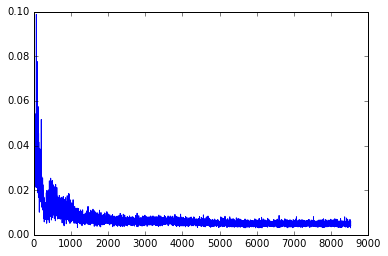

In [13]:
dqn.graphLoss()